# `causalml` - Meta-Learner Example Notebook

# Introduction
CausalML is a Python package that provides a suite of uplift modeling and causal inference methods using machine learning algorithms based on recent research. It provides a standard interface that allows user to estimate the Conditional Average Treatment Effect (CATE) or Individual Treatment Effect (ITE) from experimental or observational data. Essentially, it estimates the causal impact of intervention T on outcome Y for users with observed features X, without strong assumptions on the model form.  The package currently supports the following methods:
- Tree-based algorithms
    - Uplift tree/random forests on KL divergence, Euclidean Distance, and Chi-Square
    - Uplift tree/random forests on Contextual Treatment Selection
- Meta-learner algorithms
    - S-learner
    - T-learner
    - X-learner
    - R-learner
    
In this notebook, we will generate some synthetic data to demonstrate how to use the various Meta-Learner algorithms in order to estimate Individual Treatment Effects (and Average Treatment Effects with confidence intervals).

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSLearner
from causalml.inference.meta import XGBTLearner, MLPTLearner
from causalml.inference.meta import BaseXLearner, BaseRLearner, BaseSLearner, BaseTLearner
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

# Part A: Example Workflow using Synthetic Data

### 1. Generate synthetic data
- We have implemented 4 modes of generating synthetic data (specified by input parameter `mode`). Refer to the References section for more detail on these data generation processes.

In [222]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=5000, p=8, sigma=1.0)

### 3. Calculate Propensity Scores
Although we have propensity scores (`e`) generated from the `synthetic_data` function, typically in reality we aren't able to directly observe these values (unless a separate model has been independently developed for the treatment flag, in which case we could use that). `causalml` has a light-weight propensity model that allows you to specify the features to estimate treatment-propensity from.

*Note that propensity scores are only used for X Learner and R Learner.*

In [223]:
# Predict p_hat because e would not be directly observed in real-life
p_model = ElasticNetPropensityModel()
p_hat = p_model.fit_predict(X=X, y=treatment)

### 4a. Matching

The `NearestNeighborMatch` class expects a Pandas DataFrame when `match()` is called, so first we package the existing features data `X` into a dataframe. 

In [483]:
TREATMENT_COL = 'is_treatment'
PROPENSITY_COL = 'pihat'
OUTCOME_COL = 'y'

df = pd.DataFrame(X, columns=['X{}'.format(i) for i in range(X.shape[1])])
df[TREATMENT_COL] = treatment
df[PROPENSITY_COL] = p_hat
df[OUTCOME_COL] = y

df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,is_treatment,pihat,y
0,0.527734,0.555947,0.809605,0.736226,0.231055,0.618805,0.930124,0.406769,1,0.579833,1.561632
1,0.101952,0.598730,0.288345,0.858782,0.876765,0.223267,0.260486,0.610931,0,0.312209,0.966061
2,0.817196,0.054489,0.202593,0.896855,0.993143,0.129571,0.380644,0.837443,0,0.416579,2.301927
3,0.788788,0.588713,0.993091,0.383643,0.297544,0.534467,0.979629,0.292948,1,0.785764,1.990103
4,0.994469,0.826757,0.155585,0.477405,0.367926,0.605384,0.672590,0.820990,0,0.992432,1.106419


Next, we instantiate `NearestNeighborMatch` and define `score_cols` to specify the matcher to match on just the propensity variable.

In [485]:
matcher = NearestNeighborMatch()
score_cols = [PROPENSITY_COL]
df_matched = matcher.match(data=df, treatment_col=TREATMENT_COL, score_cols=score_cols)

# define your own covariates to check matched balance
covariates_to_check = [col for col in df_matched if col != TREATMENT_COL and col != OUTCOME_COL]

create_table_one(data=df_matched, treatment_col=TREATMENT_COL, features=covariates_to_check)

,Control,Treatment,SMD
Variable,,,
n,1243,1243,
X0,0.51 (0.31),0.51 (0.25),-0.0002
X1,0.51 (0.32),0.50 (0.25),-0.0243
X2,0.50 (0.29),0.51 (0.29),0.0218
X3,0.49 (0.29),0.49 (0.29),-0.0055
X4,0.50 (0.29),0.51 (0.29),0.0398
X5,0.49 (0.29),0.49 (0.29),-0.0066
X6,0.50 (0.28),0.50 (0.28),-0.0001
X7,0.49 (0.29),0.50 (0.29),0.0383


SMD is the standardized mean difference of the variable between the two classes (Control and Treatment). An SMD value of < 0.1 is typically considered a good balance. Using the synthetically generated data, we achieve good balance for all covariates when matching on the propensity score alone. However, sometimes you may find that matching purely on the propensity variable does not achieve good balance for all the covariates you would like to control for. 

Here, we introduce a noise variable that has some class imbalance and visualize it below.

### 4b. Match Optimization

In [486]:
df['noise'] = df.apply(lambda x: np.random.randn()-0.3 if x[TREATMENT_COL]==1 else np.random.randn(), axis=1)

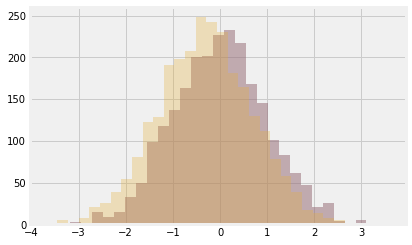

In [487]:
_ = df.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['noise'], alpha=0.3, bins=30))

Let's redo the propensity scoring + matching process and take a look at the results.

In [488]:
p_model = ElasticNetPropensityModel()
p_hat = p_model.fit_predict(X=np.hstack((X, df['noise'].values.reshape(-1,1))),
                            y=treatment)

df_matched = matcher.match(data=df, treatment_col=TREATMENT_COL, score_cols=score_cols)

# define your own covariates to check matched balance
covariates_to_check = [col for col in df_matched if col != TREATMENT_COL and col != OUTCOME_COL]

create_table_one(data=df_matched, treatment_col=TREATMENT_COL, features=covariates_to_check)

,Control,Treatment,SMD
Variable,,,
n,1248,1248,
X0,0.51 (0.31),0.50 (0.25),-0.022
X1,0.51 (0.32),0.51 (0.25),0.0033
X2,0.50 (0.29),0.49 (0.29),-0.0171
X3,0.49 (0.29),0.49 (0.29),-0.0079
X4,0.50 (0.29),0.50 (0.29),0.0029
X5,0.49 (0.29),0.50 (0.29),0.0225
X6,0.50 (0.28),0.50 (0.29),0.005
X7,0.49 (0.28),0.49 (0.29),0.0124


Now, the noise variable (which inherently has an imbalanced distribution between classes) does not achieve an acceptable SMD score. `causalml` has a built-in `MatchOptimizer` that will search for the best combinations of parameters to achieve good balance across all variables (refer to docs for more detail).

In [490]:
if 'noise' not in covariates_to_check:
    covariates_to_check.append('noise')

opt = MatchOptimizer(treatment_col=TREATMENT_COL,
                     ps_col=PROPENSITY_COL,
                     matching_covariates=covariates_to_check,
                     caliper_range=(0.01,1))
df_matched = opt.search_best_match(df)

SEARCHING FOR BEST PIHAT
Preparing match for: caliper=1.000, pihat_threshold=0.950, score_cols=['pihat']
	Score: 1.426 (Best Score: 1.426)

Preparing match for: caliper=1.000, pihat_threshold=0.962, score_cols=['pihat']
	Score: 1.345 (Best Score: 1.345)

Preparing match for: caliper=1.000, pihat_threshold=0.974, score_cols=['pihat']
	Score: 1.284 (Best Score: 1.284)

Preparing match for: caliper=1.000, pihat_threshold=0.987, score_cols=['pihat']
	Score: 1.240 (Best Score: 1.240)

Preparing match for: caliper=1.000, pihat_threshold=0.999, score_cols=['pihat']
	Score: 1.167 (Best Score: 1.167)

SEARCHING FOR BEST SCORE_COLS
Preparing match for: caliper=0.505, pihat_threshold=0.999, score_cols=['pihat', 'noise']
	Score: 0.176 (Best Score: 0.176)

SEARCHING FOR BEST CALIPER
Preparing match for: caliper=0.010, pihat_threshold=0.999, score_cols=['pihat', 'noise']
	Score: 9.491 (Best Score: 0.176)

Preparing match for: caliper=0.258, pihat_threshold=0.999, score_cols=['pihat', 'noise']
	Score

In [491]:
create_table_one(data=df_matched, treatment_col=TREATMENT_COL, features=covariates_to_check)

,Control,Treatment,SMD
Variable,,,
n,2531,2531,
X0,0.60 (0.30),0.59 (0.24),-0.0165
X1,0.61 (0.29),0.60 (0.24),-0.0655
X2,0.51 (0.29),0.51 (0.29),0.0007
X3,0.48 (0.30),0.49 (0.29),0.046
X4,0.50 (0.28),0.50 (0.29),0.0164
X5,0.49 (0.29),0.49 (0.29),0.0213
X6,0.51 (0.27),0.50 (0.29),-0.0284
X7,0.51 (0.29),0.51 (0.29),0.0012


Balance looks better now.

For the remaining sections, we will not use the introduced noise variable.

In [492]:
df_matched.drop(['noise'], axis=1, inplace=True)

### 5. Recalibrate Propensity Scores
We perform a recalibration of propensity scores to center around 0.5 (in the case of highly imbalanced pre-match data, propensity scores may be highly skewed in the lower range). 

*Note that only X-Learner and R-Learner will utilize the propensity scores in the actual estimation of treatment effects.*

In [500]:
p_model = ElasticNetPropensityModel()
df_matched['pihat_re'] = p_model.fit_predict(X=df_matched.drop([TREATMENT_COL,PROPENSITY_COL,OUTCOME_COL], axis=1),
                                             y=df_matched['is_treatment'])

### 6. Calculate Average Treatment Effect (ATE)
A meta-learner can be instantiated by calling a base learner class and providing an sklearn/xgboost regressor class as input. Alternatively, we have provided some ready-to-use learners that have already inherited their respective base learner class capabilities. This is more abstracted and allows these tools to be quickly and readily usable.

In [501]:
INFERENCE_FEATURES = [col for col in df_matched.columns if col[0]=='X'] # define your own feature list
RE_PROPENSITY_COL = 'pihat_re'

In [502]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSLearner()
ate_s = learner_s.estimate_ate(X=df_matched[INFERENCE_FEATURES],
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1]))
print('ATE upper bound: {:.03f}'.format(ate_s[2]))

(0.7249192010551735, 0.667160705596954, 0.782677696513393)
ATE estimate: 0.725
ATE lower bound: 0.667
ATE upper bound: 0.783


In [503]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTLearner()
ate_t = learner_t.estimate_ate(X=df_matched[INFERENCE_FEATURES],
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)
print('Using the ready-to-use XGBTLearner class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTLearner(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=df_matched[INFERENCE_FEATURES],
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)
print('\nUsing the BaseTLearner class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTLearner(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=df_matched[INFERENCE_FEATURES],
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)
print('\nUsing the BaseTLearner class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTLearner class
(0.6707727, 0.624065128596491, 0.7174802148025569)

Using the BaseTLearner class and using XGB (same result):
(0.6707727, 0.624065128596491, 0.7174802148025569)

Using the BaseTLearner class and using Linear Regression (different result):
(0.7262743285409694, 0.6685131867115114, 0.7840354703704274)


In [543]:
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXLearner(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=df_matched[INFERENCE_FEATURES],
                               p=df_matched[RE_PROPENSITY_COL], # note to use the recalibrated propensity here
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)
print('Using the BaseXLearner class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXLearner(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=df_matched[INFERENCE_FEATURES],
                               p=df_matched[RE_PROPENSITY_COL], # note to use the recalibrated propensity here
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)
print('\nUsing the BaseXLearner class and using Linear Regression:')
print(ate_x)

Using the BaseXLearner class and using XGB:
(0.6547931129003245, 0.6091821224746407, 0.7004041033260083)

Using the BaseXLearner class and using Linear Regression:
(0.7262743285409691, 0.6685130202378449, 0.7840356368440933)


In [544]:
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRLearner(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=df_matched[INFERENCE_FEATURES],
                               p=df_matched[RE_PROPENSITY_COL], # note to use the recalibrated propensity here
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)
print('Using the BaseXLearner class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRLearner(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=df_matched[INFERENCE_FEATURES],
                               p=df_matched[RE_PROPENSITY_COL], # note to use the recalibrated propensity here
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)
print('Using the BaseXLearner class and using Linear Regression:')
print(ate_r)

Using the BaseXLearner class and using XGB:
(0.5173796, 0.46417385797949734, 0.5705853058770091)
Using the BaseXLearner class and using Linear Regression:
(0.727668001577935, 0.6690475564058294, 0.7862884467500406)


### 7. Calculate Individual Treatment Effect (ITE/CATE)
CATE stands for Conditional Average Treatment Effect.

In [551]:
# S Learner
learner_s = LRSLearner()
cate_s = learner_s.fit_predict(X=df_matched[INFERENCE_FEATURES],
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)

# T Learner
learner_t = BaseTLearner(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=df_matched[INFERENCE_FEATURES],
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)

# X Learner
learner_x = BaseXLearner(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=df_matched[INFERENCE_FEATURES],
                               p=df_matched[RE_PROPENSITY_COL].values,
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)

# R Learner
learner_r = BaseRLearner(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=df_matched[INFERENCE_FEATURES],
                               p=df_matched[RE_PROPENSITY_COL].values,
                               treatment=df_matched[TREATMENT_COL].values,
                               y=df_matched[OUTCOME_COL].values)

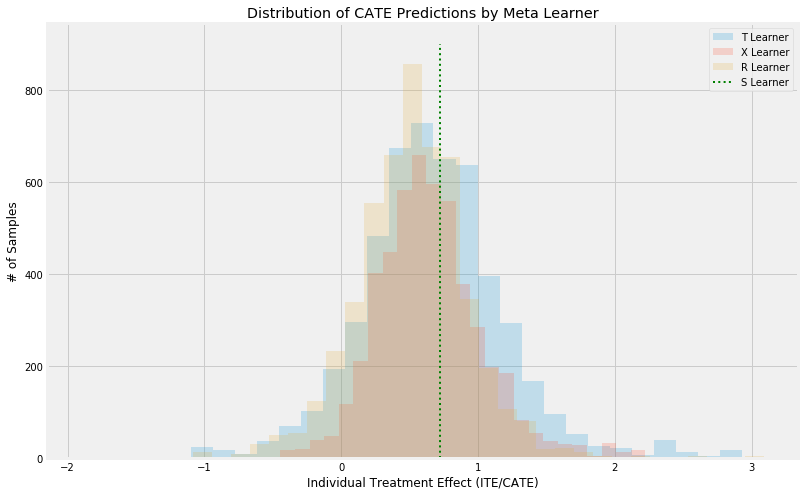

In [567]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

# Part B: Validating Meta-Learner Accuracy

We will validate the meta-learners' performance based on the same synthetic data generation method in Part A (`simulate_nuisance_and_easy_treatment`).

In [524]:
train_summary, validation_summary = get_synthetic_summary_holdout(simulate_nuisance_and_easy_treatment,
                                                                  n=10000,
                                                                  valid_size=0.2,
                                                                  k=10)

In [515]:
train_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.364297,0.075443,3.749694
S Learner (XGB),0.131430,0.023727,0.172433
T Learner (LR),0.344577,0.034458,0.302386
T Learner (XGB),0.137304,0.076339,0.325254
X Learner (LR),0.344577,0.034458,0.302386
X Learner (XGB),0.081173,0.034806,0.113421
R Learner (LR),0.292172,0.033245,0.288286
R Learner (XGB),0.083450,0.061846,0.084330


In [516]:
validation_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.358061,0.075130,3.790514
S Learner (XGB),0.130224,0.023774,0.208693
T Learner (LR),0.344976,0.034924,0.330981
T Learner (XGB),0.141496,0.073243,0.336884
X Learner (LR),0.344976,0.034924,0.330981
X Learner (XGB),0.085823,0.034278,0.137388
R Learner (LR),0.294127,0.033966,0.315483
R Learner (XGB),0.084910,0.057852,0.100323


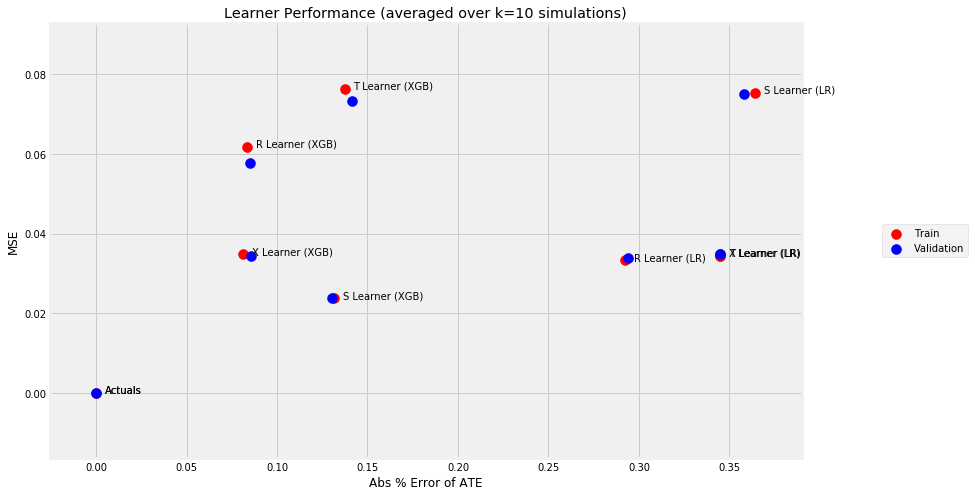

In [518]:
scatter_plot_summary_holdout(train_summary,
                             validation_summary,
                             k=10,
                             label=['Train', 'Validation'],
                             drop_learners=[],
                             drop_cols=[])

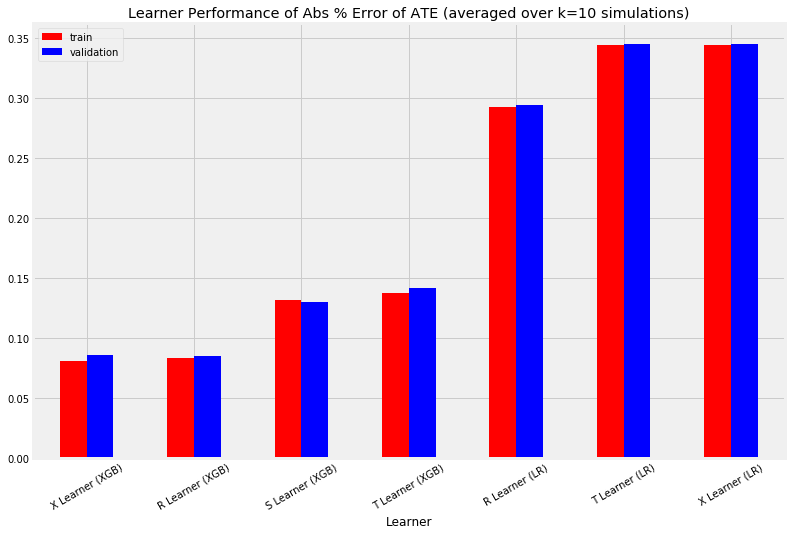

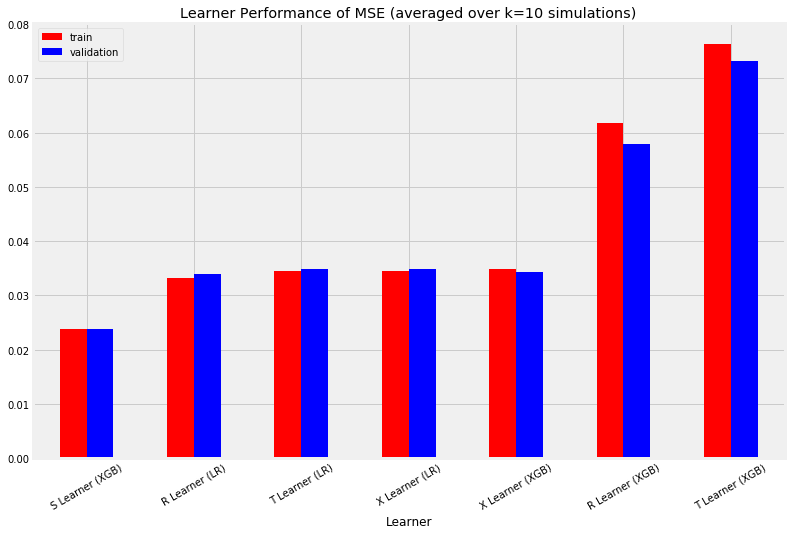

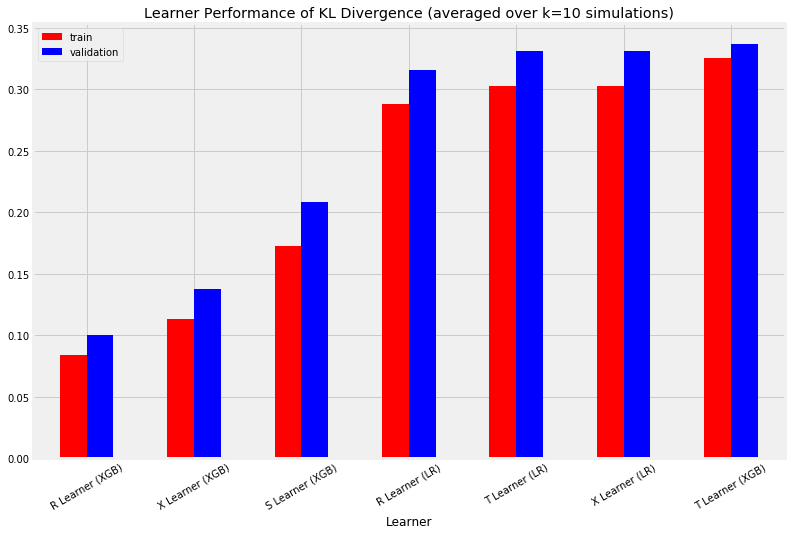

In [522]:
bar_plot_summary_holdout(train_summary,
                         validation_summary,
                         k=10,
                         drop_learners=['S Learner (LR)'],
                         drop_cols=[])

In [525]:
# Single simulation
train_preds, valid_preds = get_synthetic_preds_holdout(simulate_nuisance_and_easy_treatment,
                                                       n=50000,
                                                       valid_size=0.2)

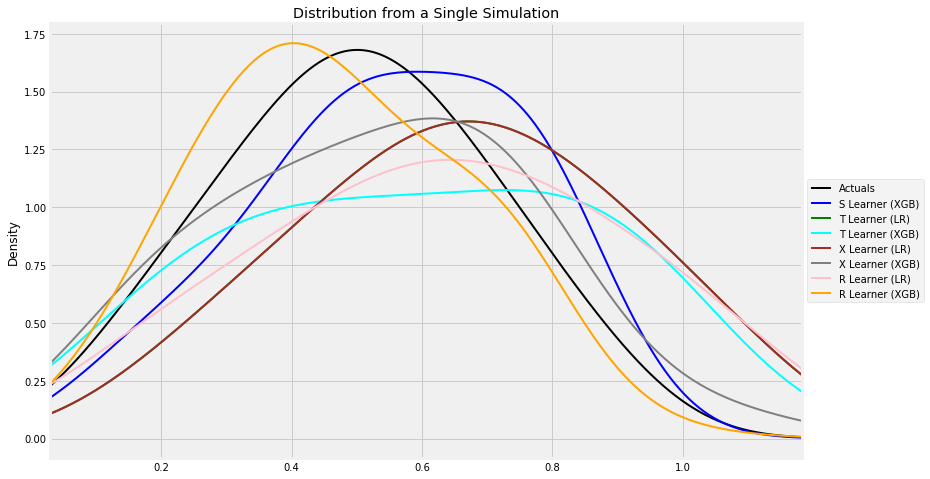

In [526]:
#distribution plot for signle simulation of Training
distr_plot_single_sim(train_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)',' S Learner (XGB)'])

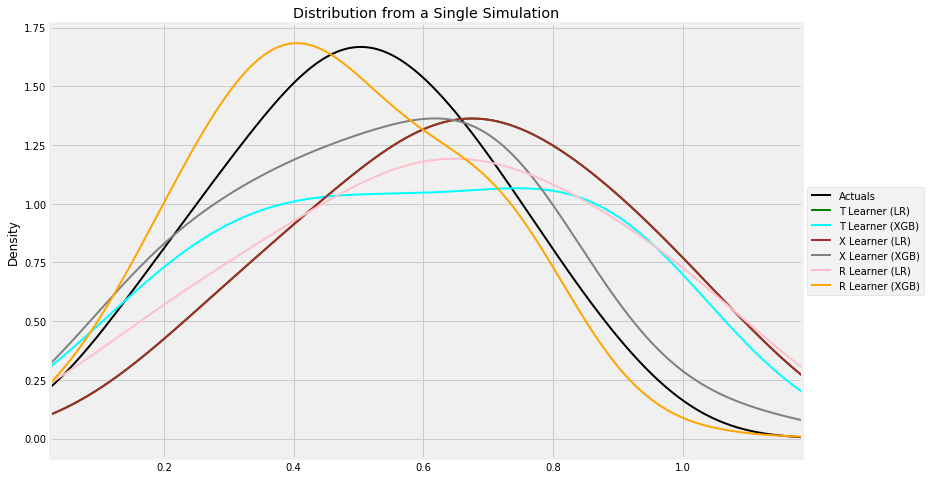

In [527]:
#distribution plot for signle simulation of Validaiton
distr_plot_single_sim(valid_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)', 'S Learner (XGB)'])

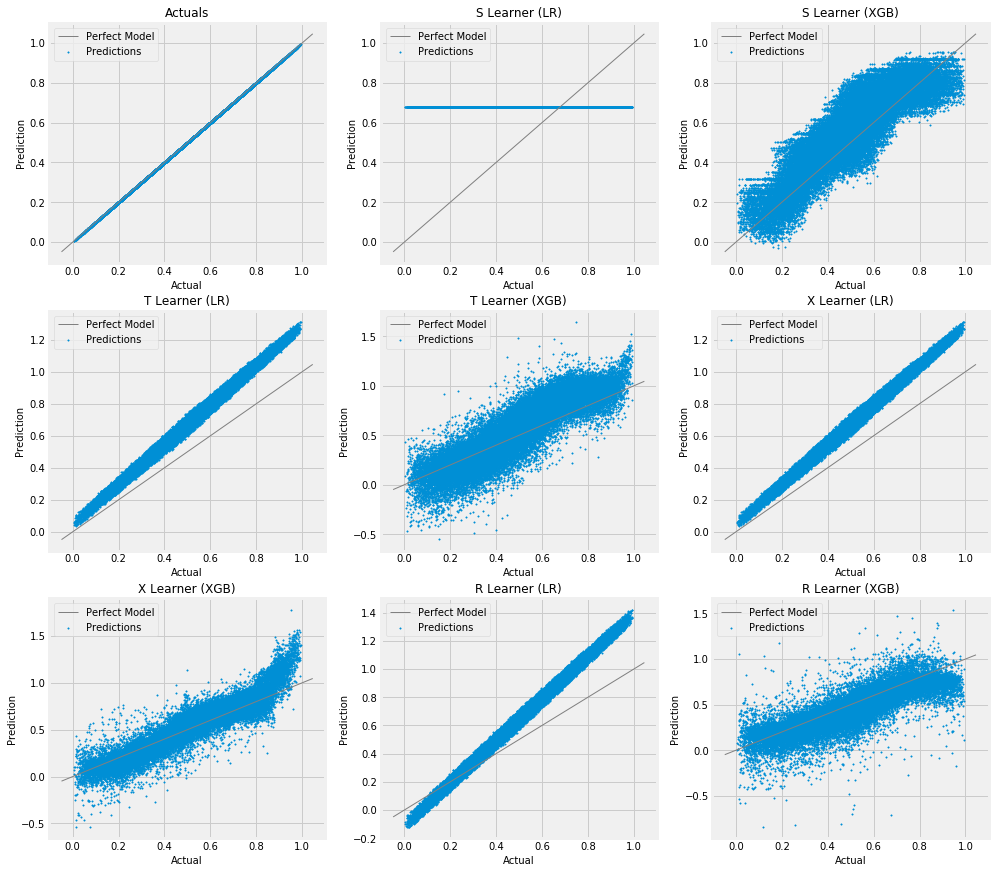

In [528]:
# Scatter Plots for a Single Simulation of Training Data
scatter_plot_single_sim(train_preds)

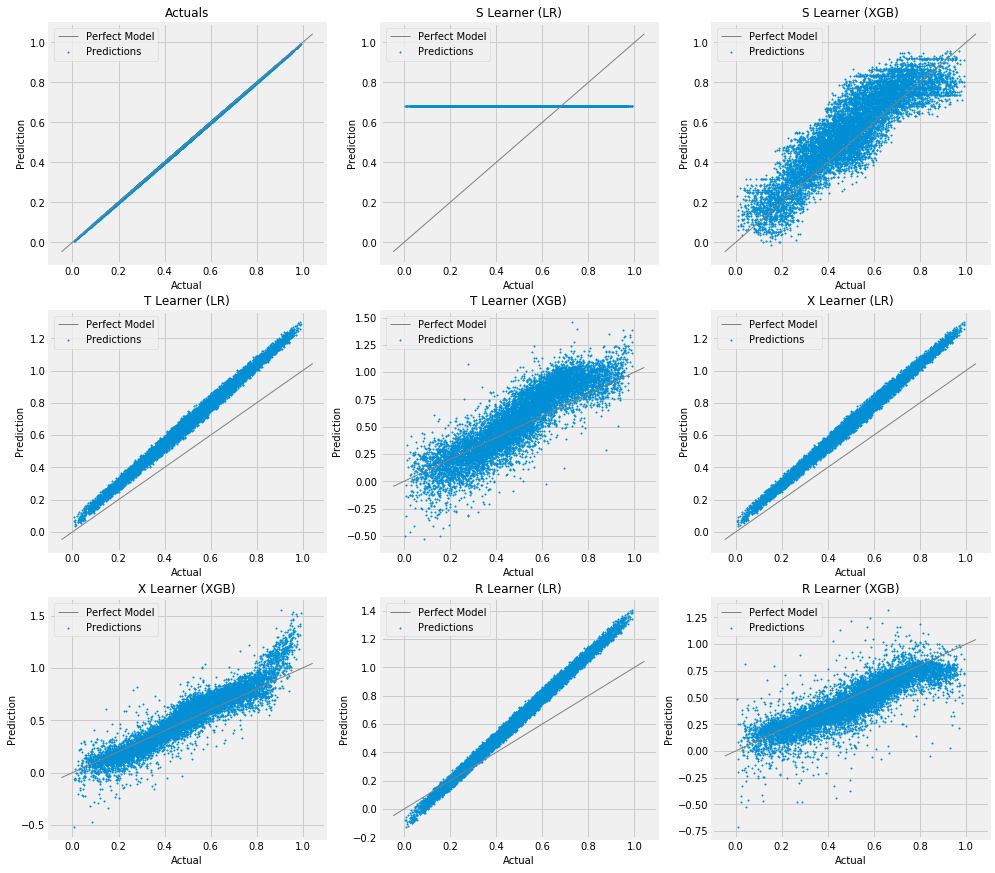

In [529]:
# Scatter Plots for a Single Simulation of Validaiton Data
scatter_plot_single_sim(valid_preds)

,Learner,cum_gain_auuc
0,Actuals,30.815533
6,R Learner (LR),30.793440
2,T Learner (LR),30.790147
4,X Learner (LR),30.790147
5,X Learner (XGB),30.479302
3,T Learner (XGB),30.211239
1,S Learner (XGB),30.181508
7,R Learner (XGB),30.121760
8,Random,24.970475


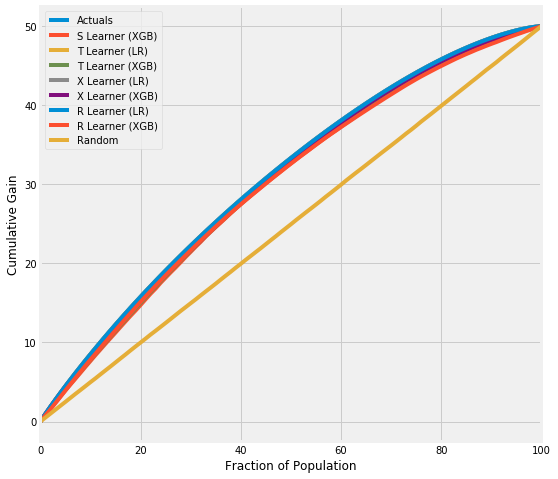

In [536]:
# Cumulative Gain AUUC values for a Single Simulation of Training Data
get_synthetic_auuc(train_preds, drop_learners=['S Learner (LR)'])

,Learner,cum_gain_auuc
0,Actuals,30.837914
6,R Learner (LR),30.815913
2,T Learner (LR),30.812957
4,X Learner (LR),30.812957
5,X Learner (XGB),30.524411
3,T Learner (XGB),30.228283
1,S Learner (XGB),30.207075
7,R Learner (XGB),30.154011
8,Random,25.099681


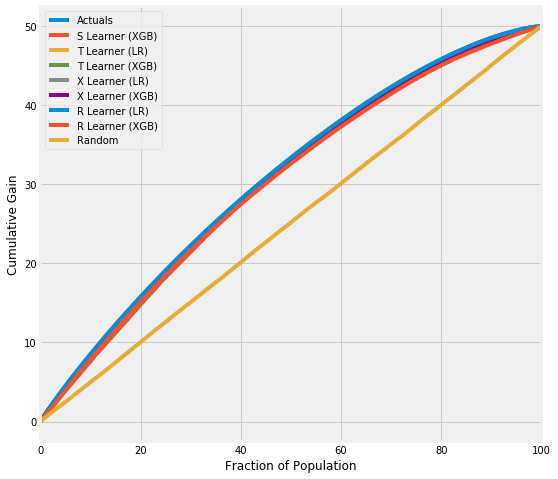

In [537]:
# Cumulative Gain AUUC values for a Single Simulation of Validaiton Data
get_synthetic_auuc(valid_preds, drop_learners=['S Learner (LR)'])